In [44]:
import importlib
import sys
from urllib.request import urlretrieve

# Install drake (and underactuated).
if 'google.colab' in sys.modules and importlib.util.find_spec('underactuated') is None:
    urlretrieve(f"http://underactuated.csail.mit.edu/scripts/setup/setup_underactuated_colab.py",
                "setup_underactuated_colab.py")
    from setup_underactuated_colab import setup_underactuated
    setup_underactuated(underactuated_sha='3e23b46200d113f9432c17b17751e16e7b42c995', drake_version='0.27.0', drake_build='release')

# Setup matplotlib.
from IPython import get_ipython
if get_ipython() is not None: get_ipython().run_line_magic("matplotlib", "inline")

# python libraries
import numpy as np
from IPython.display import HTML, display
from matplotlib import pyplot
import pydrake.all
from pydrake.all import (
    DiagramBuilder, LinearQuadraticRegulator, Saturation, SceneGraph, Simulator, MakeVectorVariable, Variable,
    WrapToSystem, AddMultibodyPlantSceneGraph, Parser, MathematicalProgram,MultibodyPlant, PlanarSceneGraphVisualizer, MultibodyForces_,
    Expression,DecomposeLumpedParameters, VectorSystem, LogOutput,DiscreteAlgebraicRiccatiEquation,  TemplateSystem, LeafSystem_, BasicVector_, 
    DiagramBuilder, Simulator_, LeafSystem, BasicVector, Integrator
)

from underactuated.jupyter import AdvanceToAndVisualize, SetupMatplotlibBackend, running_as_notebook
import numpy as np
from ipywidgets import FloatSlider, ToggleButton
from IPython.display import display, SVG
import pydot

# underactuated imports
from underactuated import FindResource, ManipulatorDynamics

import matplotlib.pyplot as plt

In [45]:
def cost_breakdown(q, u, goal, T, display=False, yscale="linear"):
  total_distance_from_target = 0
  total_actuation = 0
  goal_x = goal[0]

  distance_from_target = np.array([(q[t][0]**2 + goal_x**2)**0.5 for t in range(len(q))])
  actuation = np.array([u[t][0] for t in range(len(q))])  # assuming u_x = u_theta since that's what Jorge said

  distance_squared = distance_from_target**2
  actuation_squared = actuation**2
  cost = distance_squared + actuation_squared
  total_cost = np.sum(cost)

  if display:
    cost_sum = np.zeros(cost.shape)
    total = 0
    for i in range(cost.shape[0]):
      total += cost[i]
      cost_sum[i] = total

    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range (len(q))]
    plt.plot(times, distance_from_target, label="Distance From Target")
    plt.plot(times, actuation, label="Actuation")
    plt.plot(times, cost, label="Cost")
    plt.plot(times, cost_sum, label="Total Cost")
    plt.yscale(yscale)
    plt.legend()
    plt.show()

  return distance_from_target, actuation, cost, total_cost

def settling_time(q, u, goal, T, epsilon=1e-3):
  """ Return None if never settled """
  settling_time = None
  goal_x = goal[0]

  for t in range(q.shape[0] - 1, -1, -1):
    cur_x = q[t][0]
    if abs(cur_x - goal_x) > epsilon:  # meaning, they're unequal
      settling_time = t + 1
      break

  if abs(q[-1][0] - goal_x) > epsilon:
    return None

  time_steps = len(q)
  increment = T/time_steps
  settling_time *= increment
  return settling_time

def overshoot(q, u, goal, T, epsilon=1e-3, display=False):
  """ Return None if never reached goal """
  settling_time = None
  goal_x = goal[0]
  start_x = q[0][0]
  timestep_reached_goal = None

  if start_x < goal_x:
    for t in range(len(q)):
      cur_x = q[t][0]
      if cur_x + epsilon >= goal_x:
        timestep_reached_goal = t  # overestimate if not exactly equal
        break
  else:
    for t in range(len(q)):
      cur_x = q[t][0]
      if cur_x - epsilon <= goal_x:
        timestep_reached_goal = t  # overestimate if not exactly equal
        break

  total_overshoot = 0
  for t in range(timestep_reached_goal, len(q)):
    cur_x = q[t][0]
    total_overshoot += abs(goal_x - cur_x)

  if display:
    # here, I'll plot the distance from goal as a function of time
    xs = np.array([q[t][0] for t in range(len(q))])
    distances = xs - goal_x
    time_steps = len(q)
    increment = T/time_steps
    times = [t*increment for t in range(len(q))]
    plt.plot(times, distances)
    plt.title("Distance from Goal")
    plt.xlabel("Time (s)")
    plt.ylabel("Distance")
    plt.show()

  return total_overshoot/len(q)  # can def change this

In [46]:
ballbot_standard = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""
#here the ball is 20% heavier and has 20% more moment of inertia
ballbot_heavyball = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="6" />
      <inertia ixx=".24" ixy="0" ixz="0" iyy="0.24" iyz="0" izz="0.24" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".1" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.1</mechanicalReduction>
  </transmission>
</robot>
"""

#here the ball is 20% smaller in radius
ballbot_smallball = """
<?xml version="1.0"?>

<robot xmlns="http://drake.mit.edu"
 xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance"
 name="BallBot">

  <link name="ground">
    <visual>
      <origin xyz="0 0 -5" rpy="0 0 0" />
      <geometry>
        <box size="1000 1000 10" />
      </geometry>
      <material>
        <color rgba="0.93 .74 .4 1" />
      </material>
    </visual>
  </link>

  <joint name="ground_weld" type="fixed">
    <parent link="world" />
    <child link="ground" />
  </joint>

  <link name="ball">
    <inertial>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <mass value="5" />
      <inertia ixx=".2" ixy="0" ixz="0" iyy="0.2" iyz="0" izz="0.2" />
    </inertial>
    <visual>
      <origin xyz="0 0 0" rpy="0 0 0" />
      <geometry>
        <sphere radius=".08" />
      </geometry>
      <material>
        <color rgba="0.25 0.52 0.96 1" />
      </material>
    </visual>
  </link>

  <link name="bot">
    <inertial>
      <origin xyz="0 0 .05" rpy="0 0 0" />
      <mass value="4" />
      <inertia ixx="0.10" ixy="0" ixz="0" iyy="0.18" iyz="0" izz="0.1" />
    </inertial>
    <visual>
      <origin xyz="0 0 .04" rpy="0 0 0" />
      <geometry>
         <cylinder length=".1" radius=".12" />
      </geometry>
      <material>
        <color rgba=".61 .63 .67 1" />
      </material>
    </visual>
  </link>
  
  <joint name="x" type="prismatic">
    <parent link="world" />
    <child link="ball" />
    <origin xyz="0 0 .1" />
    <axis xyz="1 0 0" />
    <dynamics damping="0.1" />
  </joint>
   

  <joint name="theta1" type="continuous">
    <parent link="ball" />
    <child link="bot" />
    <origin xyz="0 0 0" />
    <axis xyz="0 1 0" />
    <dynamics damping="0.1" />
  </joint>


  <transmission type="SimpleTransmission" name="ball_torque">
    <actuator name="torque" />
    <joint name="theta1" />
    <mechanicalReduction>1</mechanicalReduction>
  </transmission>

  <transmission type="SimpleTransmission" name="ball_force">
    <actuator name="force" />
    <joint name="x" />
    <mechanicalReduction>.08</mechanicalReduction>
  </transmission>
</robot>
"""

Now lets get to the actual FUN part here we'll have a helper function to create the ball bot, then we'll create a few different diagrams to hook it up to different controllers and plot the results!

In [47]:
#[position X ,theta, xdot, theat_dot, integrator]
start1 = [1,0,0,0,0]
start2 = [-1,np.pi/4,0,0,0]
start3= [-0.5, 1,0,0,0]
x_star = [0,0,0,0]
Q = np.diag((10., 10., 1., 1.))
R = np.eye(1)
timestep = 0.01
Duration = 30 

In [48]:
#this reutnrs a connected ball bot
def BallBot(urdif):
  builder = DiagramBuilder()
  ballbot, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=0.0)
  Parser(ballbot).AddModelFromString(urdif, "urdf")
  ballbot.set_name("ballbot")
  ballbot.Finalize()

  B = np.array([[1],[1]])

  gain = builder.AddSystem(pydrake.systems.primitives.MatrixGain(B))
  gain.set_name("Actuator Mapping")

  builder.Connect(gain.get_output_port(),ballbot.get_actuation_input_port())
  builder.ExportInput(gain.get_input_port(),"torque")
  builder.ExportOutput(ballbot.get_state_output_port(), "continuous_state")
  builder.ExportOutput(scene_graph.get_query_output_port(), "query")
  builder.ExportOutput(scene_graph.get_pose_bundle_output_port(), "pose")

  return builder.Build(),scene_graph

#Running cost thing copied from lecture
@TemplateSystem.define("RunningCost_")
def RunningCost_(T):

    class Impl(LeafSystem_[T]):

        def _construct(self, converter=None):
            LeafSystem_[T].__init__(self, converter)
            self.DeclareVectorInputPort("state", BasicVector_[T](4))
            self.DeclareVectorInputPort("command", BasicVector_[T](1))
            self.DeclareVectorOutputPort("cost", BasicVector_[T](1),self.CostOutput)

        def _construct_copy(self, other, converter=None):
            Impl._construct(self, converter=converter)

        def CostOutput(self, context, output):
            x = self.get_input_port(0).Eval(context)
            u = self.get_input_port(1).Eval(context)
            #print("X",x,"u",u)
            #print("Q",Q)
            #print("R",R)
            #print()
            a = x.T@(Q@(x)) + R.dot(u**2)
            output[0] = a[0]

    return Impl
x = np.array([0,1,1,0])
u = np.array([0])
print((x.dot(Q.dot(x)) + R.dot(u**2)))
RunningCost = RunningCost_[None]  # Default instantiation


[11.]


LQR Diagram


In [49]:
#default LQR 
def defaultLQR():
  defaultBallBot,scene_graph = BallBot(ballbot_standard)
  input_i = defaultBallBot.get_input_port().get_index()
  context = defaultBallBot.CreateDefaultContext()
  context.get_mutable_continuous_state_vector().SetFromVector(x_star)
  defaultBallBot.get_input_port().FixValue(context, [0])


  return LinearQuadraticRegulator(defaultBallBot, context, Q, R, input_port_index=input_i)

def buildLQR(urdf):
  builder = DiagramBuilder()

  ballbotsystem,scene_graph = BallBot(urdf)
  ballbotsystem.set_name("System BallBot")
  ballbotsystem = builder.AddSystem(ballbotsystem)



  # set the operating point (vertical unstable equilibrium)
  context = ballbotsystem.CreateDefaultContext()
  context.get_mutable_continuous_state_vector().SetFromVector(x_star)

  # fix the input port to zero and get its index for the lqr function
  ballbotsystem.get_input_port().FixValue(context, [0])
  input_i = ballbotsystem.get_input_port().get_index()
  states = LogOutput(ballbotsystem.get_output_port(0),builder)

  # synthesize lqr controller directly from
  # the nonlinear system and the operating point

  lqr = builder.AddSystem(defaultLQR())
  lqr.set_name("LQR")
  torques = LogOutput(lqr.get_output_port(0),builder)
  # wire cart-pole and lqr
  builder.Connect(ballbotsystem.GetOutputPort("continuous_state"), lqr.get_input_port(0))
  builder.Connect(lqr.get_output_port(0), ballbotsystem.get_input_port())

  #This didn't work so I ignored it
  running_cost = builder.AddSystem(RunningCost())
  running_cost.set_name("running_cost")
  running_cost_logger = LogOutput(running_cost.get_output_port(0),builder)
  builder.Connect(ballbotsystem.GetOutputPort("continuous_state"), running_cost.get_input_port(0))
  builder.Connect(lqr.get_output_port(0), running_cost.get_input_port(1))

  #integrated
  cost = builder.AddSystem(Integrator(1))
  cost.set_name("integrator")
  builder.Connect(running_cost.get_output_port(), cost.get_input_port())
  cost_logger = LogOutput(cost.get_output_port(0),builder)
  #cost = LogOutput(running_cost.get_output_port(),builder)
  # add a visualizer and wire it
  visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-2., 2.], ylim=[-.4, 1.5], show=False)
  )


  builder.Connect(ballbotsystem.GetOutputPort("pose"), visualizer.get_input_port(0))

  # finish building the block diagram
  diagram = builder.Build()
  #display(SVG(pydot.graph_from_dot_data(diagram.GetGraphvizString())[0].create_svg()))
  # instantiate a simulator
  simulator = Simulator(diagram)
  simulator.set_publish_every_time_step(False) # makes sim faster
  return context,visualizer,states,torques,running_cost_logger,cost_logger,simulator
  
def simulate_and_animate(x0, urdf, sim_time=10):
    context, visualizer,states,torques,running_cost,cost, simulator = buildLQR(urdf)

    # start recording the video for the animation of the simulation
    visualizer.start_recording()
    
    # reset initial time and state
    context = simulator.get_mutable_context()
    context.SetTime(0.)
    context.SetContinuousState(x0)

    # run sim
    simulator.Initialize()
    simulator.AdvanceTo(sim_time)
    
    # stop video
    visualizer.stop_recording()
    
    # construct animation
    ani = visualizer.get_recording_as_animation()
    
    # display animation below the cell
    display(HTML(ani.to_jshtml()))
    
    # reset to empty video
    return states,torques,running_cost,cost

In [50]:
class Policy(VectorSystem):

    def __init__(self):
        # 4 inputs: ball bot state [q, q_dot]
        # 1 output: control torque [u]
        VectorSystem.__init__(self, 4,  1)
        self.timestep=0.01        

    def DoCalcVectorOutput(self, context, state, unused, torque):
        torque[:] = 1 #[self.us[0,ind[0],0,0]]

def simulate_policy(start_state,urdf):
  # Instantiate the policy system
  # Wire up the drake diagram

  policy = Policy()
  builder = DiagramBuilder() # instantiate a diagram builder
  ballbotsystem,scene_graph = BallBot(urdf)
  ballbotsystem.set_name("System BallBot")
  
  plant = builder.AddSystem(ballbotsystem) # add a sub-system to it
  vi_policy = builder.AddSystem(policy)
  builder.Connect(plant.GetOutputPort("continuous_state"), vi_policy.get_input_port(0)) # connecting inputs/outputs of two sub-systems in our diagram
  builder.Connect(vi_policy.get_output_port(0), plant.get_input_port())
   
  states = LogOutput(plant.get_output_port(0),builder)
  torques = LogOutput(vi_policy.get_output_port(0),builder)
  
  visualizer = builder.AddSystem(
    PlanarSceneGraphVisualizer(scene_graph, xlim=[-3., 2.], ylim=[-.4, 1.5], show=False)
  )

  builder.Connect(plant.GetOutputPort("pose"), visualizer.get_input_port(0))


  running_cost = builder.AddSystem(RunningCost())
  running_cost.set_name("running_cost")
  running_cost_logger = LogOutput(running_cost.get_output_port(0),builder)
  
  builder.Connect(ballbotsystem.GetOutputPort("continuous_state"), running_cost.get_input_port(0))
  builder.Connect(vi_policy.get_output_port(0), running_cost.get_input_port(1))

  #integrated
  cost = builder.AddSystem(Integrator(1))
  cost.set_name("integrator")
  builder.Connect(running_cost.get_output_port(), cost.get_input_port())

  cost_logger = LogOutput(cost.get_output_port(0),builder)
  
  diagram = builder.Build() # finish building the diagram

  # Simulate the system
  simulator = Simulator(diagram)
  simulator.get_mutable_context().SetContinuousState(start_state) # set the initial state
  AdvanceToAndVisualize(simulator, visualizer,10)

  return states,torques,running_cost_logger,cost_logger

simulating...  done.
generating animation...


Max cost for ballbot_standard: 217470.60397934733
simulating...  done.
generating animation...


Max cost for ballbot_heavyball: 217245.41363888152
simulating...  done.
generating animation...


Max cost for ballbot_smallball: 217470.60397934733


Text(0.5, 1.0, 'Cost')

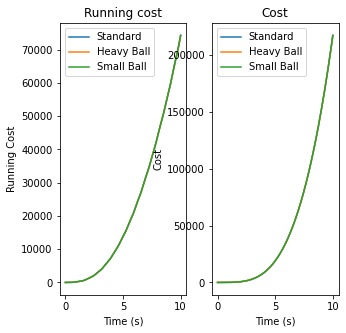

In [51]:
fig, ax = plt.subplots(1,2)
fig.set_size_inches(5, 5)

states, torques, running_cost, cost = simulate_policy(start1, ballbot_standard)
ax[0].plot(running_cost.sample_times(), running_cost.data().T)
ax[1].plot(cost.sample_times(), cost.data().T)
print('Max cost for ballbot_standard:', cost.data().max())

states, torques, running_cost, cost = simulate_policy(start1,ballbot_heavyball)
ax[0].plot(running_cost.sample_times(), running_cost.data().T)
ax[1].plot(cost.sample_times(), cost.data().T)
print('Max cost for ballbot_heavyball:', cost.data().max())

states, torques, running_cost, cost = simulate_policy(start1,ballbot_smallball)
ax[0].plot(running_cost.sample_times(), running_cost.data().T)
ax[0].legend(["Standard","Heavy Ball","Small Ball"])

ax[1].plot(cost.sample_times(), cost.data().T)
ax[1].legend(["Standard","Heavy Ball","Small Ball"])
print('Max cost for ballbot_smallball:', cost.data().max())

ax[0].set_ylabel("Running Cost")
ax[0].set_xlabel("Time (s)")
ax[0].set_title("Running cost")

ax[1].set_ylabel("Cost")
ax[1].set_xlabel("Time (s)")
ax[1].set_title("Cost")

simulating...  done.
generating animation...


simulating...  done.
generating animation...


simulating...  done.
generating animation...


Text(0.5, 0, 'Time (s)')

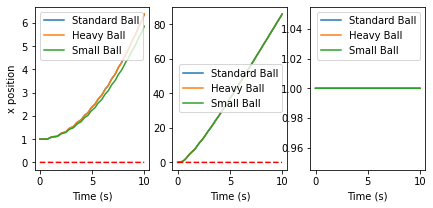

In [52]:
# set up axis
fig, ax = plt.subplots(1,3)
fig.set_size_inches(7, 3)

# simulate standard ballbot
states, torques, running_cost, cost = simulate_policy(start1, ballbot_standard)
state_data = states.data()
state_data_sample_times = states.sample_times()
x_data = state_data[0,:]
theta_data = state_data[1,:]
torque_data = torques.data()[0,:]
torque_data_sample_times = torques.sample_times()

ax[0].plot(state_data_sample_times, x_data)
ax[1].plot(state_data_sample_times, theta_data)
ax[2].plot(torque_data_sample_times, torque_data)

# simulate small ballbot
states, torques, running_cost, cost = simulate_policy(start1, ballbot_smallball)
state_data = states.data()
state_data_sample_times = states.sample_times()
x_data = state_data[0,:]
theta_data = state_data[1,:]
torque_data = torques.data()[0,:]
torque_data_sample_times = torques.sample_times()

ax[0].plot(state_data_sample_times, x_data)
ax[1].plot(state_data_sample_times, theta_data)
ax[2].plot(torque_data_sample_times, torque_data)

# simulate heavy ballbot
states, torques, running_cost, cost = simulate_policy(start1,ballbot_heavyball)
state_data = states.data()
state_data_sample_times = states.sample_times()
x_data = state_data[0,:]
theta_data = state_data[1,:]
torque_data = torques.data()[0,:]
torque_data_sample_times = torques.sample_times()

ax[0].plot(state_data_sample_times, x_data)
ax[1].plot(state_data_sample_times, theta_data)
ax[2].plot(torque_data_sample_times, torque_data)

ax[0].legend(["Standard Ball","Heavy Ball","Small Ball"])
ax[1].legend(["Standard Ball","Heavy Ball","Small Ball"])
ax[2].legend(["Standard Ball","Heavy Ball","Small Ball"])

# add goal line 

ax[0].plot(state_data_sample_times, np.zeros_like(x_data), 'r--')
ax[1].plot(state_data_sample_times, np.zeros_like(theta_data),'r--')

ax[0].set_ylabel("x position")
ax[0].set_xlabel("Time (s)")

ax[1].set_xlabel("theta rotation")
ax[1].set_xlabel("Time (s)")

ax[2].set_xlabel("actuator torque")
ax[2].set_xlabel("Time (s)")